In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
import json
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
import numpy as np
from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
from functools import reduce
import pickle

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/kyryl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kyryl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kyryl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kyryl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
with open('../data/ragnarock.json', encoding='utf-8', errors='ignore') as json_file:
    json_data = json.load(json_file)
json_messages = json_data['messages']
messages = []
for message in json_messages[:1000]:
    text = message['text']
    string_list = []
    for entity in text:
        if isinstance(entity, str):
            string_list.append(entity)
        elif isinstance(entity, dict):
            string_list.append(entity['text'])
    string_list = [s for s in string_list if s]
    if string_list:
        messages.append(''.join(string_list))

messages_df = pd.DataFrame({'raw_text': messages})
messages_df.head(10)

,raw_text
0,"Какие предсказания пацаны ,будем анимэ?"
1,⚡️Международный аэропорт Харькова закрыт на пр...
2,"Жить будем пацаны ,устроим встречу подписчиков..."
3,https://t.me/joinchat/Uxs7-tq2uRtIzthH\n\nССЫЛ...
4,⚡️Владимир Зеленский заявил о поставке Францие...
5,⚡️Пацаны не надейтесь ни на кого кроме своих б...
6,"❗️""Сегодня я инициировал телефонный звонок с п..."
7,"Кива, который сейчас загорает в Испании попрос..."
8,❗️Украина полностью отключилась от российских ...
9,❗️Россия закрывает несколько участков воздушно...


In [3]:
morph_ru = MorphAnalyzer(lang='ru')
morph_uk = MorphAnalyzer(lang='uk')
lemmatizer_en = WordNetLemmatizer()


def remove_url(text):
    return re.sub(r"http\S+", "", text)


def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation + '«»—–-’'))
    return text.replace('\n', ' ').replace('\u200b', '')


def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\u203C"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def tokenize_text(text):
    if not text:
        return text
    detected_language = detect(text)
    language = 'english' if detected_language == 'en' else 'russian'
    words = word_tokenize(text, language=language)
    if detected_language == 'uk':
        return [morph_uk.parse(word)[0].normal_form for word in words]
    elif detected_language == 'en':
        return [lemmatizer_en.lemmatize(word) for word in words]
    else:
        return [morph_ru.parse(word)[0].normal_form for word in words]


with open('../data/stopwords_ua.txt') as file:
    ukrainian_stopwords = file.read().splitlines()

stop_words = set(stopwords.words('english') + stopwords.words('russian') + ukrainian_stopwords)


def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

In [4]:
def transform_text(text):
    return reduce(lambda text, function: function(text),
                  [remove_url, remove_punctuation, remove_emoji, tokenize_text, remove_stopwords], text)

In [5]:
messages_df['words'] = messages_df['raw_text'].apply(transform_text)
messages_df.head(10)

,raw_text,words
0,"Какие предсказания пацаны ,будем анимэ?","[предсказание, пацан, анимэ]"
1,⚡️Международный аэропорт Харькова закрыт на пр...,"[международный, аэропорт, харьков, закрытый, п..."
2,"Жить будем пацаны ,устроим встречу подписчиков...","[жить, пацан, устроить, встреча, подписчик, до..."
3,https://t.me/joinchat/Uxs7-tq2uRtIzthH\n\nССЫЛ...,"[ссылка, телеграм, ragnarock, privet, пригласи..."
4,⚡️Владимир Зеленский заявил о поставке Францие...,"[владимир, зеленский, заявить, поставка, франц..."
5,⚡️Пацаны не надейтесь ни на кого кроме своих б...,"[пацан, надеяться, кроме, свой, близкий, сооте..."
6,"❗️""Сегодня я инициировал телефонный звонок с п...","[сегодня, инициировать, телефонный, звонок, пр..."
7,"Кива, который сейчас загорает в Испании попрос...","[кива, который, загорать, испания, попросить, ..."
8,❗️Украина полностью отключилась от российских ...,"[украина, полностью, отключиться, российский, ..."
9,❗️Россия закрывает несколько участков воздушно...,"[россия, закрывать, несколько, участок, воздуш..."


In [6]:
words = pd.Series(np.concatenate(messages_df['words']))
words_count = words.value_counts()
words_count.head()

украина       174
российский    112
канал          93
киев           86
это            80
dtype: int64

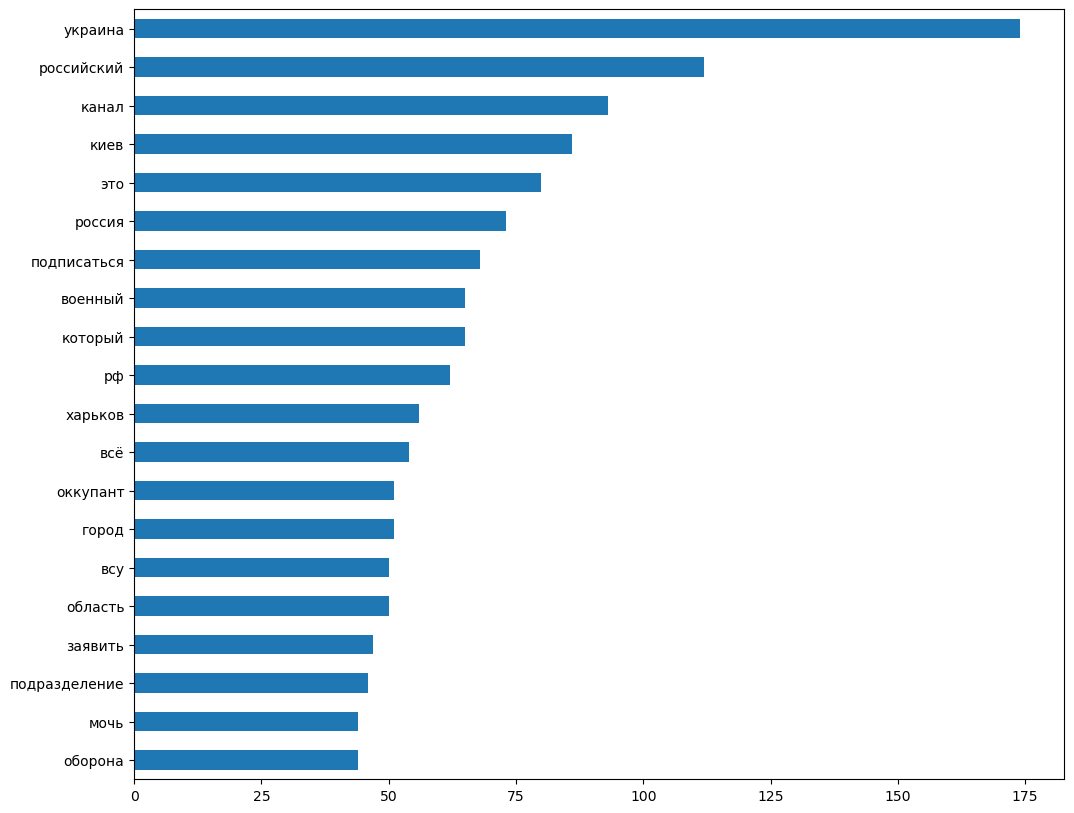

In [7]:
plt.figure(figsize=(12, 10))
words_count.head(20).plot.barh()
plt.gca().invert_yaxis();

In [8]:
extra_stopwords = {'это', 'подписаться', 'всё'}

In [9]:
messages_df['words'] = messages_df['words'].apply(lambda words: [word for word in words if word not in extra_stopwords])
messages_df.head()

,raw_text,words
0,"Какие предсказания пацаны ,будем анимэ?","[предсказание, пацан, анимэ]"
1,⚡️Международный аэропорт Харькова закрыт на пр...,"[международный, аэропорт, харьков, закрытый, п..."
2,"Жить будем пацаны ,устроим встречу подписчиков...","[жить, пацан, устроить, встреча, подписчик, до..."
3,https://t.me/joinchat/Uxs7-tq2uRtIzthH\n\nССЫЛ...,"[ссылка, телеграм, ragnarock, privet, пригласи..."
4,⚡️Владимир Зеленский заявил о поставке Францие...,"[владимир, зеленский, заявить, поставка, франц..."


In [10]:
messages_df['normalized_text'] = messages_df['words'].str.join(' ')
messages_df.head()

,raw_text,words,normalized_text
0,"Какие предсказания пацаны ,будем анимэ?","[предсказание, пацан, анимэ]",предсказание пацан анимэ
1,⚡️Международный аэропорт Харькова закрыт на пр...,"[международный, аэропорт, харьков, закрытый, п...",международный аэропорт харьков закрытый приём ...
2,"Жить будем пацаны ,устроим встречу подписчиков...","[жить, пацан, устроить, встреча, подписчик, до...",жить пацан устроить встреча подписчик донбассе...
3,https://t.me/joinchat/Uxs7-tq2uRtIzthH\n\nССЫЛ...,"[ссылка, телеграм, ragnarock, privet, пригласи...",ссылка телеграм ragnarock privet пригласить друг
4,⚡️Владимир Зеленский заявил о поставке Францие...,"[владимир, зеленский, заявить, поставка, франц...",владимир зеленский заявить поставка франция ср...


In [11]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(messages_df['normalized_text'])
bag_of_words = pd.DataFrame(bag_of_words.toarray(), columns=cv.get_feature_names_out())
bag_of_words.head()

,000,0139,015,0185,020,025,031,04,050,055,...,ім,ін,інструкція,інф,інформаційний,інформація,інфраструктура,їжувід,їми,їсти
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
with open('../data/bag_of_words_matrix.pkl', 'wb') as file:
    pickle.dump(bag_of_words, file)
with open('../data/vocabulary.pkl', 'wb') as file:
    pickle.dump(cv.vocabulary_, file)

In [13]:
tfidf_vectorizer = TfidfVectorizer()

In [14]:
tfidf_matrix = tfidf_vectorizer.fit_transform(messages_df['normalized_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

In [15]:
words = pd.Series(np.concatenate(messages_df['words']))
words_count = words.value_counts()

In [16]:
top_words_df = messages_df[['raw_text']].copy()
for word in words_count.head(10).index:
    top_words_df[word] = 0
    word_index = np.where(feature_names == word)[0][0]
    for document_index, _ in top_words_df.iterrows():
        top_words_df.loc[document_index, word] = tfidf_matrix[document_index, word_index]
top_words_df

,raw_text,украина,российский,канал,киев,россия,военный,который,рф,харьков,город
0,"Какие предсказания пацаны ,будем анимэ?",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,⚡️Международный аэропорт Харькова закрыт на пр...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125176,0.0
2,"Жить будем пацаны ,устроим встречу подписчиков...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,https://t.me/joinchat/Uxs7-tq2uRtIzthH\n\nССЫЛ...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,⚡️Владимир Зеленский заявил о поставке Францие...,0.101376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
816,⚡️ Буча. Киевская область. Активные бои. \n\nН...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
817,Рузкие «тигры» горят на улицах Харькова,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281246,0.0
818,"⚡️На Троещине взрыв, идёт дым",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
819,❗️ Сейчас коронавирус в ахуе капитулирует с пл...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
